In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')  

import meneame as mn
import s3_create_attitudes as s3

import pandas as pd

import networkx as nx
import numpy as np
import pylab as plt
import seaborn as sns

import textalloc as ta
from sklearn.impute import KNNImputer

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [2]:
# Set up paths and topics to study
# Read folder paths from the file
with open('../dirs.txt', 'r') as f:
    lines = [line.strip() for line in f]

path = lines[0]

# Define the data path
path_data = path + 'data_snapshot/'
path_save_embeddings = "../data/embeddings/"
path_figures = lines[1]


topics = ["Politics", "Russia",  "Public services", "Crime", "Crypto/net", "Inflation"]

# Part 1: User-story (bipartite network of outlets and users voting)

This section analyzes how users vote on stories (typically news articles or posts), treating it as a bipartite network between users and story outlets (domains).

Steps:
* Loads voting data tied to stories.
* Filters it to a relevant time window.
* Filters out social media platforms: Twitter, YouTube, and the host site (Meneame).
* Computes agreement levels per story (e.g., how many votes are positive).
* Creates descriptive statistics for the bipartite network.
* Calculates the SHEEP and CA embeddings


In [3]:
# Read comments and merges with topics
data = mn.read_comments_topics(path_data, bipartite=True)
data = data.loc[(data["story_vote_time"] >= "2022-12-01") &
                (data["story_vote_time"] <= "2023-08-01")]

Data time range 2022-11-26 23:04:00, 2023-08-08 19:55:00


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_35790/702255136.py:7: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: (np.sum(x) - 1) / (len(x) - 1)
/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_35790/702255136.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: (np.sum(x) - 1) / (len(x) - 1)


final_topic
Politics           411591
Public services     85154
Russia              77828
Crime               73465
Inflation           26724
Crypto/net          26533
Name: count, dtype: int64


final_topic      story_vote
Crime             1             69074
                 -1              4391
Crypto/net        1             24414
                 -1              2119
Inflation         1             25316
                 -1              1408
Politics          1            378528
                 -1             33063
Public services   1             81637
                 -1              3517
Russia            1             64240
                 -1             13588
Name: count, dtype: int64

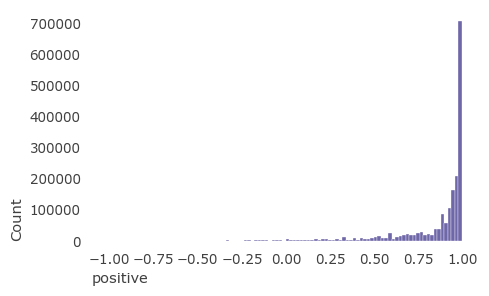

In [4]:
# Keep domains that we are interested in, so we can filter on them later
domains = set(data["story_original_url_domain"].unique()) - {"twitter", "youtube", "meneame"}
domains_and_users = domains | set(data["username_post"].unique()) 

# Agreement (all storeis has at least one positive vote)
data["positive"] = data.groupby("story_id")["story_vote"].transform(
    lambda x: (np.sum(x) - 1) / (len(x) - 1)
)
sns.histplot(data["positive"], bins=100)

# Only publised
data["topic"] = data["final_topic"] 
data = data.loc[data["final_topic"].isin(set(topics))]


print(data["final_topic"].value_counts())
data.groupby("final_topic")["story_vote"].value_counts()


### Descriptive statistics

This section provides an exploratory overview of the story vote data:
* Visualizes the distribution of vote timestamps to check for scraping gaps or anomalies.
* Uses the print_stats() function to:
    * Report how many users/outlets participate per topic.
    * Compare full datasets versus subsets with less than 95% positive votes.



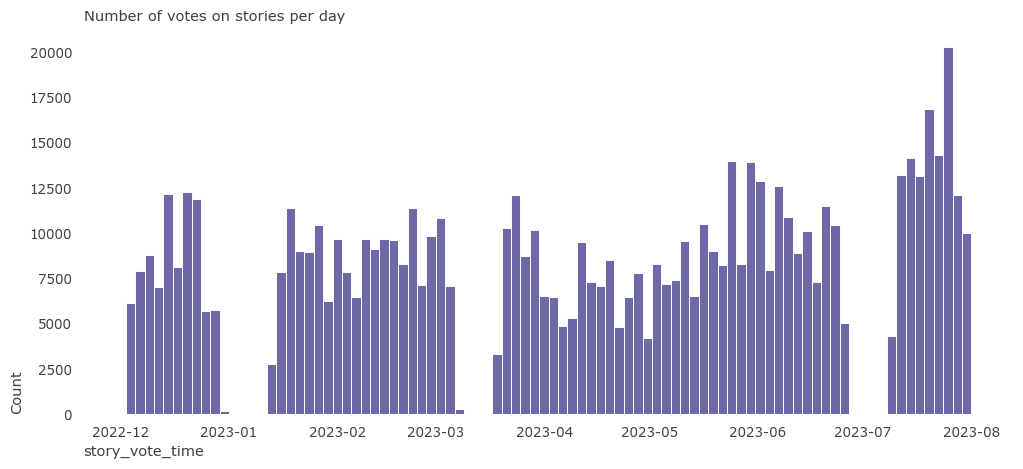

In [5]:
# Note: there were problems with the scraping in 3 weeks
plt.figure(figsize=(12,5))
sns.histplot(data["story_vote_time"])
plt.title("Number of votes on stories per day")
plt.savefig(f"{path_figures}/2023-08-01_histogram_story_vote_time.pdf")

In [6]:
print("ALL VOTES")
s3.print_stats(data)
print("--> filtering out only positive")
s3.print_stats(data.loc[data["positive"]<0.95])


ALL VOTES
Crime: N. users: 4903, N. outlets/commenters: 315. Votes: 45004 (+1), 2818 (-1)
Crypto/net: N. users: 3839, N. outlets/commenters: 282. Votes: 19789 (+1), 1771 (-1)
Inflation: N. users: 3314, N. outlets/commenters: 175. Votes: 16663 (+1), 986 (-1)
Politics: N. users: 7704, N. outlets/commenters: 673. Votes: 114432 (+1), 10764 (-1)
Public services: N. users: 5145, N. outlets/commenters: 316. Votes: 44458 (+1), 2164 (-1)
Russia: N. users: 4412, N. outlets/commenters: 563. Votes: 42845 (+1), 7705 (-1)
--> filtering out only positive
Crime: N. users: 3976, N. outlets/commenters: 229. Votes: 24206 (+1), 2906 (-1)
Crypto/net: N. users: 2858, N. outlets/commenters: 196. Votes: 10004 (+1), 1781 (-1)
Inflation: N. users: 2429, N. outlets/commenters: 108. Votes: 7568 (+1), 1029 (-1)
Politics: N. users: 6814, N. outlets/commenters: 498. Votes: 71452 (+1), 11343 (-1)
Public services: N. users: 3845, N. outlets/commenters: 195. Votes: 19505 (+1), 2220 (-1)
Russia: N. users: 3930, N. outle

Graph with 1291 nodes and 19466 edges


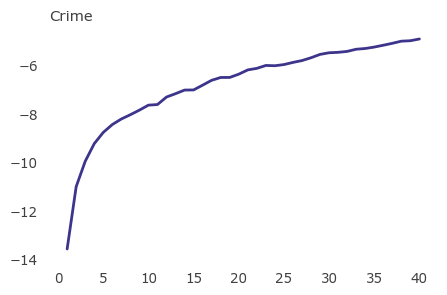

Graph with 610 nodes and 4263 edges


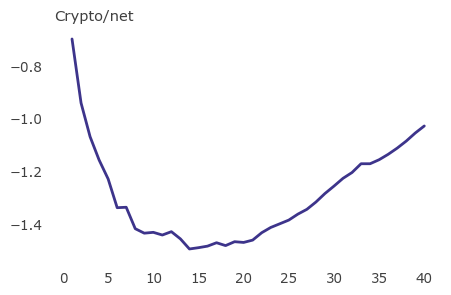

Graph with 643 nodes and 4473 edges


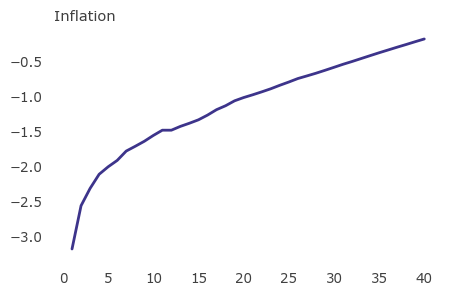

Graph with 3318 nodes and 77371 edges


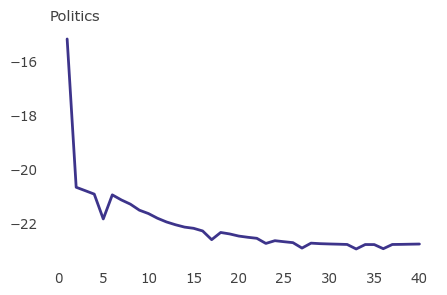

Graph with 1462 nodes and 20814 edges


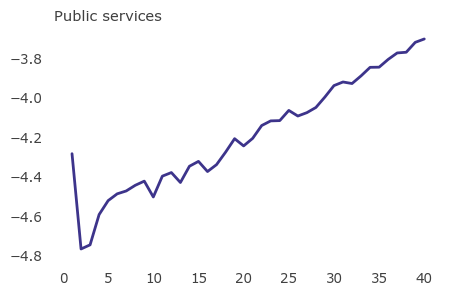

Graph with 1229 nodes and 17045 edges


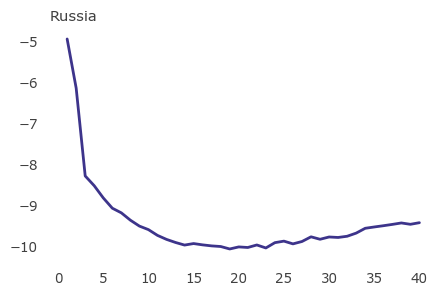

Graph with 1288 nodes and 18554 edges
Graph with 605 nodes and 4041 edges
Graph with 642 nodes and 4348 edges
Graph with 3304 nodes and 72145 edges
Graph with 1456 nodes and 20121 edges
Graph with 1219 nodes and 15070 edges
Politics
Politics dim:  33
Expained variance: [0.17679348 0.12769769 0.07694674]
Russia
Russia dim:  19
Expained variance: [0.50237513 0.24570521 0.06951522]
Public services
Public services dim:  2
Expained variance: [0.84341148 0.15658852]
Crime
Crime dim:  1
Expained variance: [1.]
Crypto/net
Crypto/net dim:  14
Expained variance: [0.27638364 0.23044751 0.14313614]
Inflation
Inflation dim:  1
Expained variance: [1.]
Politics
Politics dim:  17
Expained variance: [0.15329067 0.12020641 0.0978061 ]
Russia
Russia dim:  11
Expained variance: [0.15762808 0.13924257 0.125228  ]
Public services
Public services dim:  11
Expained variance: [0.23949587 0.14954412 0.13166039]
Crime
Crime dim:  13
Expained variance: [0.15015073 0.14080733 0.13497527]
Crypto/net
Crypto/net dim:

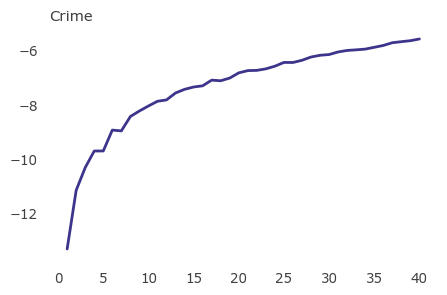

Graph with 309 nodes and 1229 edges


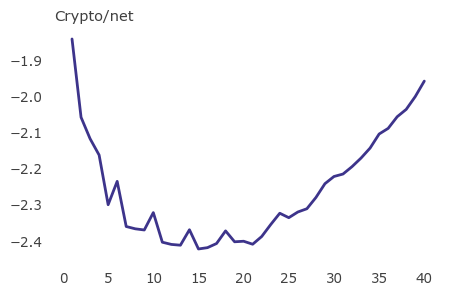

Graph with 268 nodes and 1082 edges


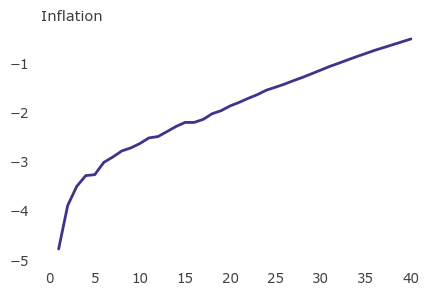

Graph with 2670 nodes and 49301 edges


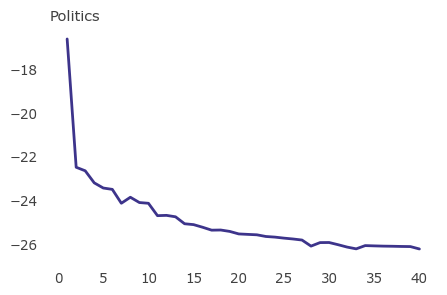

Graph with 753 nodes and 6878 edges


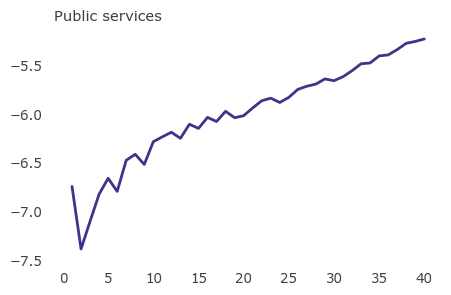

Graph with 1004 nodes and 11158 edges


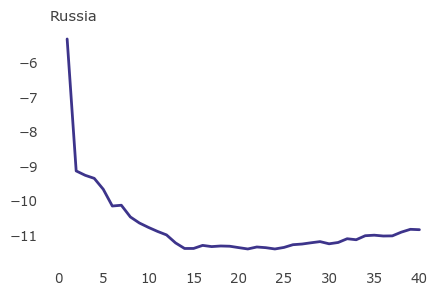

Graph with 785 nodes and 7615 edges
Graph with 294 nodes and 1097 edges
Graph with 265 nodes and 1004 edges
Graph with 2648 nodes and 44053 edges
Graph with 742 nodes and 6421 edges
Graph with 990 nodes and 9400 edges
Politics
Politics dim:  40
Expained variance: [0.2006057  0.10148066 0.07323704]
Russia
Russia dim:  24
Expained variance: [0.4751759  0.21234743 0.08051118]
Public services
Public services dim:  2
Expained variance: [0.79316173 0.20683827]
Crime
Crime dim:  1
Expained variance: [1.]
Crypto/net
Crypto/net dim:  15
Expained variance: [0.3177739  0.22454985 0.19878269]
Inflation
Inflation dim:  1
Expained variance: [1.]
Politics
Politics dim:  14
Expained variance: [0.16909015 0.161343   0.11016195]
Russia
Russia dim:  9
Expained variance: [0.18152949 0.17107602 0.15244252]
Public services
Public services dim:  6
Expained variance: [0.33313472 0.19556315 0.17516966]
Crime
Crime dim:  9
Expained variance: [0.20435988 0.16859005 0.13683952]
Crypto/net
Crypto/net dim:  3
Expai

In [7]:
for min_comments_or_stories in [10]:
    # Calculate embeddings
    s3.calculate_embeddings(data, path_save_embeddings, min_comments_or_stories, last_suffix="_all")

    # Run PCA
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_bipartite_normed_False_min_votes_{min_comments_or_stories}_all.csv",
        f"{path_save_embeddings}/embeddings_ca_bipartite_min_votes_{min_comments_or_stories}_all.csv",
    ]:
        s3.run_pca(path, topics, domains)
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_bipartite_normed_False_no_outliers_min_votes_{min_comments_or_stories}_all.csv",
        f"{path_save_embeddings}/embeddings_ca_bipartite_no_outliers_min_votes_{min_comments_or_stories}_all.csv",
    ]:
        s3.run_pca(path, topics, domains)

data = data.loc[(data["positive"] < 0.95)]
for min_comments_or_stories in [10]:
    # Calculate embeddings
    s3.calculate_embeddings(data, path_save_embeddings, min_comments_or_stories, last_suffix="_all_no_only_positive")

    # Run PCA
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_bipartite_normed_False_min_votes_{min_comments_or_stories}_all_no_only_positive.csv",
        f"{path_save_embeddings}/embeddings_ca_bipartite_min_votes_{min_comments_or_stories}_all_no_only_positive.csv",
    ]:
        s3.run_pca(path, topics, domains)
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_bipartite_normed_False_no_outliers_min_votes_{min_comments_or_stories}_all_no_only_positive.csv",
        f"{path_save_embeddings}/embeddings_ca_bipartite_no_outliers_min_votes_{min_comments_or_stories}_all_no_only_positive.csv",
    ]:
        s3.run_pca(path, topics, domains)


# Part 2: User-user network
This block shifts the focus to comment votes, creating a unipartite user–user network:
* Loads and filters comment vote data in the same date range.
* Calculates agreement within comment threads (how positive the interactions are).
* Crates descriptive statistics for the user-user network.
* Calculates the SHEEP and CA embeddings.

Data time range 2022-11-14 11:42:20, 2023-08-09 12:46:05


/var/folders/ct/x16mp19d2vj70t8msd2jzp400000gn/T/ipykernel_35790/66226827.py:7: FutureWarning: The provided callable <function mean at 0x1042ca020> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data["positive"] = data.groupby("story_id")["comment_vote"].transform(


final_topic
Politics           770037
Russia             231613
Crime              141704
Public services    119109
Crypto/net          47820
Inflation           40791
Name: count, dtype: int64


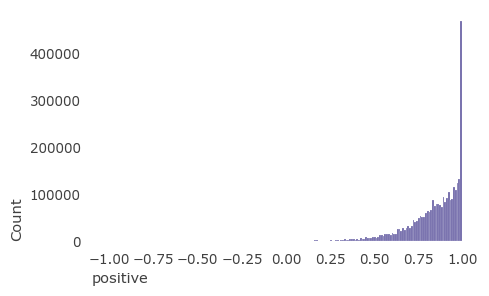

In [8]:
# # Read comments and merges with topics
data = mn.read_comments_topics(path_data)
data = data.loc[(data["comment_vote_time"] >= "2022-12-01") &
                (data["comment_vote_time"] <= "2023-08-01")]

# Agreement
data["positive"] = data.groupby("story_id")["comment_vote"].transform(
    np.mean
)

# Keep domains to filter later on
domains_users = set(data["username_post"].unique()) | set(data["username_vote"].unique())

sns.histplot(data["positive"], bins=200)

# Only publised
data["topic"] = data["final_topic"]  # .map(mn.topic_names) # Add name of each topic
data = data.loc[data["final_topic"].isin(set(topics))]

print(data["final_topic"].value_counts())

In [9]:
# Print descriptive statistics
s3.print_stats(data, type_vote="comment")
print("--> filtering out only positive")
s3.print_stats(data.loc[data["positive"]<0.95], type_vote="comment")

Crime: N. users: 4789, N. outlets/commenters: 3322. Votes: 101234 (+1), 10858 (-1)
Crypto/net: N. users: 3602, N. outlets/commenters: 2451. Votes: 38994 (+1), 1778 (-1)
Inflation: N. users: 3125, N. outlets/commenters: 1986. Votes: 30677 (+1), 2400 (-1)
Politics: N. users: 6571, N. outlets/commenters: 5049. Votes: 390578 (+1), 43283 (-1)
Public services: N. users: 4640, N. outlets/commenters: 3295. Votes: 89483 (+1), 6856 (-1)
Russia: N. users: 4038, N. outlets/commenters: 2644. Votes: 103427 (+1), 11401 (-1)
--> filtering out only positive
Crime: N. users: 4461, N. outlets/commenters: 2918. Votes: 78304 (+1), 10714 (-1)
Crypto/net: N. users: 2864, N. outlets/commenters: 1677. Votes: 20542 (+1), 1626 (-1)
Inflation: N. users: 2623, N. outlets/commenters: 1513. Votes: 19309 (+1), 2293 (-1)
Politics: N. users: 6255, N. outlets/commenters: 4608. Votes: 310957 (+1), 42972 (-1)
Public services: N. users: 4215, N. outlets/commenters: 2744. Votes: 59777 (+1), 6641 (-1)
Russia: N. users: 3786,

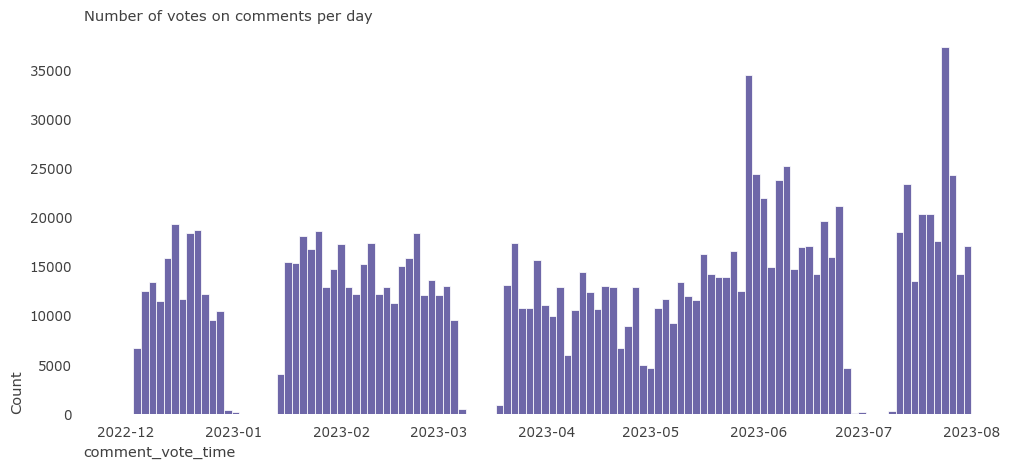

In [10]:
# Same problems wth scraping in same 3 weeks
plt.figure(figsize=(12,5))
sns.histplot(data["comment_vote_time"])
plt.title("Number of votes on comments per day")
plt.savefig(f"{path_figures}/2023-08-01_histogram_comment_vote_time.pdf")

Graph with 2090 nodes and 67677 edges


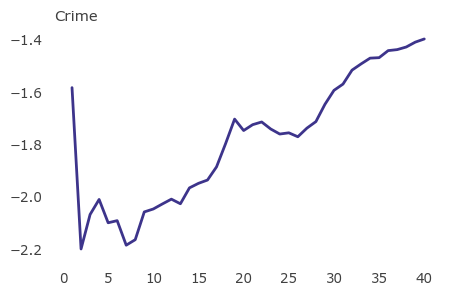

Graph with 1050 nodes and 14726 edges


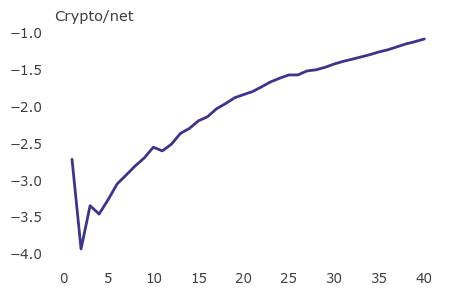

Graph with 874 nodes and 12169 edges


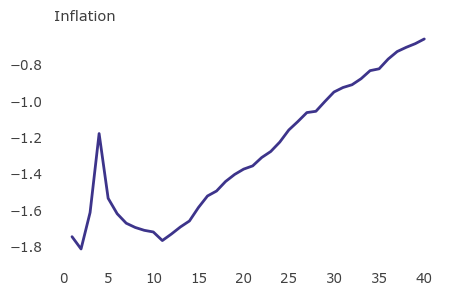

Graph with 3899 nodes and 360312 edges


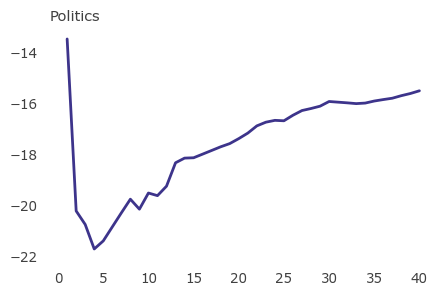

Graph with 1915 nodes and 55326 edges


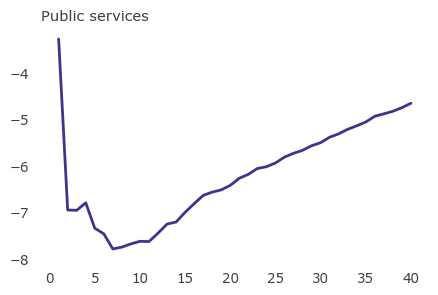

Graph with 1774 nodes and 79306 edges


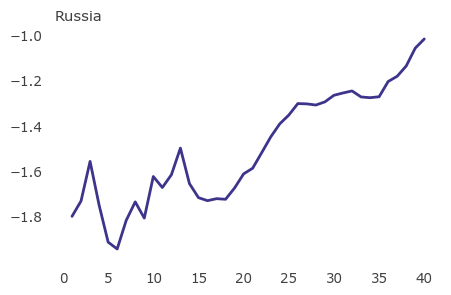

Graph with 2088 nodes and 61641 edges
['user', 'Crime_0', 'Crime_1', 'Crime_2']
                                       user  Crime_0_x  Crime_1_x  Crime_2_x  \
0  000614c1608a193e65c9d588ce98006ccb6aa741   0.587763  -0.841732  -0.706271   
1  1c8faa878acb80a85a6b6808b0000ab03c5d77c5  -0.220368   0.266755  -0.074154   

   Crime_0_y  Crime_1_y  Crime_2_y  
0   0.715315   0.622154   0.555300  
1  -0.279607  -0.251712   0.112719  
           Crime_0_x  Crime_1_x  Crime_2_x  Crime_0_y  Crime_1_y  Crime_2_y
Crime_0_x   1.000000  -0.038007  -0.460449   0.980594  -0.244963   0.409117
Crime_1_x  -0.038007   1.000000   0.051787  -0.210338  -0.940352  -0.040731
Crime_2_x  -0.460449   0.051787   1.000000  -0.424058   0.171070  -0.987549
Crime_0_y   0.980594  -0.210338  -0.424058   1.000000  -0.073120   0.369294
Crime_1_y  -0.244963  -0.940352   0.171070  -0.073120   1.000000  -0.167111
Crime_2_y   0.409117  -0.040731  -0.987549   0.369294  -0.167111   1.000000
Graph with 1050 nodes and 14072 edge

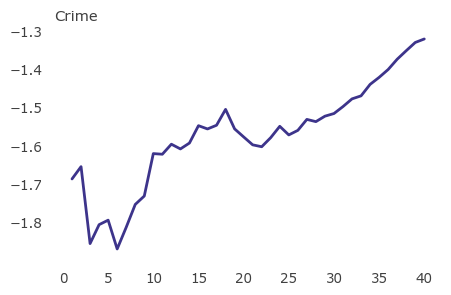

Graph with 895 nodes and 9264 edges


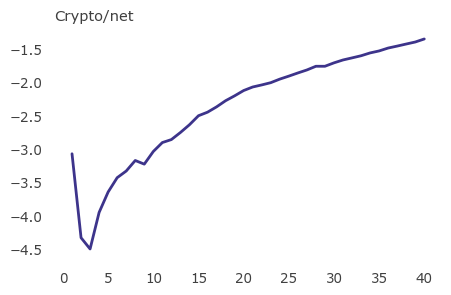

Graph with 784 nodes and 8570 edges


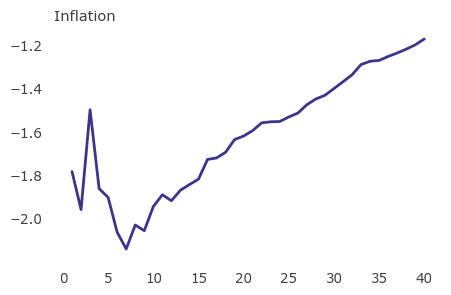

Graph with 3803 nodes and 332035 edges


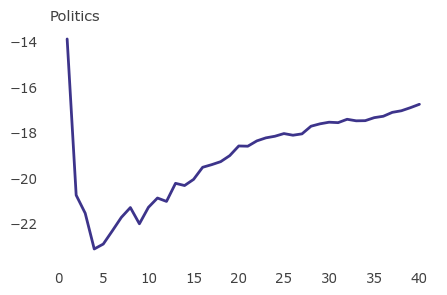

Graph with 1800 nodes and 44756 edges


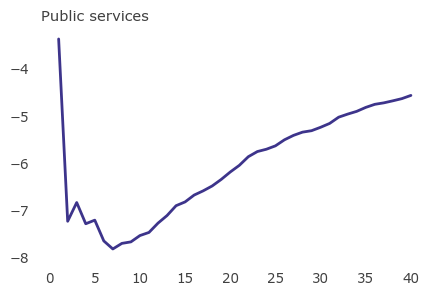

Graph with 1706 nodes and 73925 edges


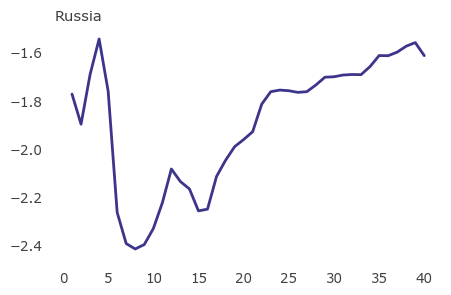

Graph with 2002 nodes and 53238 edges
['user', 'Crime_0', 'Crime_1', 'Crime_2']
                                       user  Crime_0_x  Crime_1_x  Crime_2_x  \
0  000614c1608a193e65c9d588ce98006ccb6aa741   0.539245   0.867393  -0.659946   
1  1c8faa878acb80a85a6b6808b0000ab03c5d77c5  -0.189925  -0.458301  -0.120158   

   Crime_0_y  Crime_1_y  Crime_2_y  
0   0.716575  -0.613784   0.523072  
1  -0.314162   0.434348   0.165697  
           Crime_0_x  Crime_1_x  Crime_2_x  Crime_0_y  Crime_1_y  Crime_2_y
Crime_0_x   1.000000   0.032051  -0.502774   0.969484   0.357401   0.445651
Crime_1_x   0.032051   1.000000  -0.081039   0.249136  -0.891263   0.068568
Crime_2_x  -0.502774  -0.081039   1.000000  -0.460338  -0.242845  -0.988103
Crime_0_y   0.969484   0.249136  -0.460338   1.000000   0.142710   0.399675
Crime_1_y   0.357401  -0.891263  -0.242845   0.142710   1.000000   0.234652
Crime_2_y   0.445651   0.068568  -0.988103   0.399675   0.234652   1.000000
Graph with 894 nodes and 8749 edges


In [11]:
for min_comments_or_stories in [10]:
    # Calculate embeddings
    s3.calculate_embeddings(data, path_save_embeddings, min_comments_or_stories, norm_laplacian=True, bipartite=False, last_suffix="_all")

    # Run PCA
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_unipartite_normed_True_min_votes_{min_comments_or_stories}_all.csv",
        f"{path_save_embeddings}/embeddings_ca_unipartite_min_votes_{min_comments_or_stories}_all.csv",
    ]:
        s3.run_pca(path, topics, domains_users)
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_unipartite_normed_True_no_outliers_min_votes_{min_comments_or_stories}_all.csv",
        f"{path_save_embeddings}/embeddings_ca_unipartite_no_outliers_min_votes_{min_comments_or_stories}_all.csv",
    ]:
        s3.run_pca(path, topics, domains_users)



# This affects CA a lot, not SHEEP
data = data.loc[data["positive"] < 1]

for min_comments_or_stories in [10]:
    # Calculate embeddings
    s3.calculate_embeddings(data, path_save_embeddings, min_comments_or_stories, norm_laplacian=True, bipartite=False, last_suffix="_no_only_positive")

    # Run PCA
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_unipartite_normed_True_min_votes_{min_comments_or_stories}_no_only_positive.csv",
        f"{path_save_embeddings}/embeddings_ca_unipartite_min_votes_{min_comments_or_stories}_no_only_positive.csv",
    ]:
        s3.run_pca(path, topics, domains_users)
    for path in [
        f"{path_save_embeddings}/embeddings_sheep_unipartite_normed_True_no_outliers_min_votes_{min_comments_or_stories}_no_only_positive.csv",
        f"{path_save_embeddings}/embeddings_ca_unipartite_no_outliers_min_votes_{min_comments_or_stories}_no_only_positive.csv",
    ]:
        s3.run_pca(path, topics, domains_users)

